In [1]:
# evaluating machine translation quality using real eBay UK product listings
%matplotlib inline


from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
from langdetect import detect_langs
from pathlib import Path
import openai
from pydantic import BaseModel
import json
import numpy as np
from datetime import datetime
from jsonschema import validate, ValidationError
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Raw Data Extaction
------------------------------------------------------------------------------------------------------------------------------------------------------'''
CATEGORY_URL = "https://www.ebay.co.uk/b/bn_2316025" #Household Accessories & Supplies -> Cookware, Dining & Bar -> Kitchen Tools & Gadgets

def scrape_ebay_product_listing(cat_url, max_pages=1):
    listings = []
    
    # initializing driver
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options=options)

    for page in range(1, max_pages + 1):
            page_url = f"{cat_url}?_pgn={page}"
            print(f"Scraping {page_url}")

            driver.get(page_url)
            time.sleep(10)

            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")

            ul_elem = soup.find("ul", class_="brwrvr__item-results brwrvr__item-results--list")

            if ul_elem:
                for li in ul_elem.find_all("li", class_="brwrvr__item-card"):
                    # Title
                    title_elem = li.find("h3", class_="textual-display bsig__title__text")
                    title = title_elem.get_text(strip=True) if title_elem else None
            
                    # URL
                    link_elem = li.find("a", class_="bsig__title__wrapper")
                    url = link_elem['href'] if link_elem else None
            
                    # Price
                    price_elem = li.find("span", class_="textual-display bsig__price bsig__price--displayprice")
                    price = price_elem.get_text(strip=True) if price_elem else None
            
                    if title and url and price:
                        listings.append({
                            "title": title,
                            "url": url,
                            "price": price
                        })
    
    driver.quit()
    return listings 


data = scrape_ebay_product_listing(CATEGORY_URL, max_pages=2)
df_raw = pd.DataFrame(data)
# print(df_raw.head())
# print(len(df_raw))

Scraping https://www.ebay.co.uk/b/bn_2316025?_pgn=1
Scraping https://www.ebay.co.uk/b/bn_2316025?_pgn=2


In [7]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Raw Data Pre-processing - ETL
------------------------------------------------------------------------------------------------------------------------------------------------------'''
# 1. Drop nulls
df_cleaned = df_raw.dropna(subset=["title", "price", "url"])

# 2. Basic normalization
noises = [
    "professional",           
    "premium",                
    "brand new",              
    "new listing",            
    "genuine",       
    "world's best",           
    "uk stock",               
    "custom(?:ised| engraved| printed)?",
    "handmade",               
    "limited edition",        
    "clearance",             
    "discount",               
    "hot deal",              
    "free shipping",          
    "100% (?:authentic|real)"
]

def remove_noise_phrases(text, phrases=noises):
    for phrase in phrases:
        pattern = re.compile(rf"\b{phrase}\b", flags=re.IGNORECASE)
        text = pattern.sub(" ", text)
    return re.sub(r"\s+", " ", text).strip()

def replace_symbols(text):
    replacements = {
        r"\|": ",",       # pipe → comma
        r"&": " and ",    # ampersand → and
        r"\+": " plus ",  # plus sign → plus
        r"@": " at ",     # at sign → at
        "%":" pct "       # % sign → pct
    }
    for pat, sub in replacements.items():
        text = re.sub(pat, sub, text)
    return text

def normalize_punctuation(text):
    mapping = {
        "—": "-", "–": "-",       # em/en dash → hyphen
        "“": '"', "”": '"',       # curly quotes → straight
        "‘": "'", "’": "'",       # curly apostrophes → straight
    }
    for src, tgt in mapping.items():
        text = text.replace(src, tgt)
    return text

def remove_emojis_and_entities(text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)     # remove non-ASCII (emojis, etc.)
    text = re.sub(r"&\w+;", " ", text)             # remove HTML entities
    return text

def normalize_counts_and_units(text):
    """
    Normalize counts and units:
      - '2 x' → '2x'
      - '5 pcs' → '5pcs'
      - Inches: 4.3" → '4.3 inch'
      - Slashes in dims: '8/14/18cm' → '8x14x18cm'
    """
    # counts
    text = re.sub(r"(\d+)\s*[xX]\b", r"\1x", text)
    text = re.sub(r"(\d+)\s*[pP][cC][sS]?\b", lambda m: m.group(1) + "pcs", text)

    # inches
    text = re.sub(r'(\d+(?:\.\d+)?)\s*"{1,2}', r"\1 inch", text)

    # metric dims with mm/cm
    text = re.sub(r"(\d+(?:[xX]\d+)+)\s*(mm|cm)\b", r"\1\2", text, flags=re.IGNORECASE)
    
    # slashes to 'x'
    text = re.sub(r"(\d+)\/(\d+)", r"\1x\2", text)
    
    # ensure space before 'inch'
    text = re.sub(r"(\d+(?:\.\d+)?)\s*inch\b", r"\1 inch", text)
    
    return text

def normalize_title(title):
    text = title.strip().lower()
    text = normalize_counts_and_units(text)
    text = replace_symbols(text)
    text = normalize_punctuation(text)
    text = remove_emojis_and_entities(text)
    text = remove_noise_phrases(text)
    text = re.sub(r"\s+", " ", text).strip().rstrip(".")
    return text

df_cleaned['clean_title'] = df_cleaned['title'].apply(normalize_title)

# 3. Parse price
def parse_price(p):
    num = re.search(r'[\d\.,]+', p)
    return float(num.group(0).replace(',', '')) if num else None

df_cleaned["price_value"] = df_cleaned["price"].apply(parse_price)
df_cleaned["currency"] = df_cleaned["price"].str.extract(r'([A-Z]{3}|£|€|\$)')

# 4. Keep only English titles -- Note not 100% accurate
def is_english(text: str, threshold: float = 0.5):
    try:
        langs = detect_langs(text)
        if not langs:
            return False

        top = langs[0]
        return top.lang == "en" and top.prob >= threshold
    except Exception:
        return False

df_cleaned['is_eng'] = df_cleaned["clean_title"].apply(is_english)

df_cleaned_deduped = df_cleaned.drop_duplicates(subset="clean_title")
df_filtered = df_cleaned_deduped[df_cleaned_deduped['is_eng'] == True]

# print(df_cleaned.head())
print(len(df_cleaned))
print(len(df_cleaned_deduped))
print(len(df_filtered))

120
109
93


In [9]:
# dupes = df_cleaned['clean_title'].value_counts()
# print(dupes[dupes > 1])


# for row, value in df_cleaned[['title','clean_title','is_eng']][df_cleaned['is_eng'] == False].iterrows():
#     print(value['title'], 
#           '\n',
#           value['clean_title']
#          )

In [11]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Machine Translation
------------------------------------------------------------------------------------------------------------------------------------------------------'''

key_path = Path("dataops_pipeline_key.txt")
if not key_path.exists():
    raise RuntimeError("Missing openai_key.txt; please create it with your API key")
openai.api_key = key_path.read_text().strip()


df_eng = df_filtered[['clean_title','url','price','currency']].rename(columns = {'clean_title':'title'})


client = openai.OpenAI(
  api_key=openai.api_key)

# class translated_title(BaseModel):
#     original_title: str
#     translated_title: str

trans_results = ""
batch_size = 20

for i in range(0, len(df_eng), batch_size):

    batch = df_eng["title"].iloc[i : i + batch_size].tolist()
    batch_json = json.dumps(batch, ensure_ascii=False)

    inputs = [{"role":"user", "content":f"{batch_json}"}]
    
    resp = client.responses.create(
        model="gpt-4o",
        instructions="""
You are a translator, you'll translate each title in the content to Chinese one by one for all of the titles provided. Return results strictly following the format of
{"original_title":"translated_title"}, list out all translations in one line separated by comma.
        """,
        input=inputs,
        store=True
    )
    # print(inputs)
    print(resp.output_text + '\n')
    trans_results+=resp.output_text
    time.sleep(3)

{"make brunch with perfect poached eggs every time - poachies - 100 bags":"每次都能轻松煮出完美荷包蛋 - Poachies - 100 个袋子"}, {"fruit slicer peeler cutter pineapple corer parer stainless kitchen easy tool kit":"水果切片去皮切割器菠萝去芯器不锈钢厨房简易工具套装"}, {"silicone basting brush for bbq pastry and baking - heat-resistant easy to clean":"硅胶烧烤蛋糕刷 - 耐热易清洁"}, {"meat food thermometer digital temperature probe cooking jam sugar bbq turkey":"肉类食品温度计数字探针烹饪果酱糖烧烤火鸡"}, {"garlic press heavy duty stainless steel garlic crusher ginger mince kitchen tool":"大蒜压碎机重型不锈钢大蒜器生姜搅碎厨房工具"}, {"stainless steel ice cream scoop with trigger heavy duty non-stick":"不锈钢冰淇淋勺带触发器重型不粘"}, {"5pcs measuring spoons set teaspoon and tablespoon home use kitchen tool":"5 件套量匙茶匙和汤匙家用厨房工具"}, {"4pcs silicone egg frying ring fry fried poacher mould perfect for eggs pancakes":"4 件套硅胶蛋煎环煎荷包蛋模具适合煮蛋煎饼"}, {"apple cutter new steel heavy duty slicer wedger fruit corer blade handy divider":"苹果切割器新型钢制重型切片器果芯器刀片便利工具"}, {"3 pack pop up food cover large collapsible mesh

In [19]:
trans_list = []
trans_errors = ""

trans_results = re.sub(r'},\s*{', '}, {', trans_results).replace('}{','}, {')

count = 0

for x in trans_results.split('}, {'):
    x = x.lstrip('{').rstrip('}')
    x = '{' + x + '}'
    
    count+=1
    
    try:
        x_dict = json.loads(x)
        
    except:
        trans_errors+=x
        pass

    for key, value in x_dict.items():
            trans_list.append({'original_title':key,'translated_title':value})

print(f'{count} records have been processed')

if not trans_errors:
    print("All answers have been parsed successfully, there are No errors")
else:
    print(trans_errors)


df_trans = pd.DataFrame(trans_list)
# print(df_trans)
# print(len(df_trans))

93 records have been processed
All answers have been parsed successfully, there are No errors


In [21]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Machine Evaluation
------------------------------------------------------------------------------------------------------------------------------------------------------'''

def model_review(review_inputs):

    review_prompt = f"""
You are a translation quality assessor.

Rate each translation on a 4-point scale (1=Accurate, 2=Minor Error, 3=Major Error, 4=Unintelligible).
Also assign a confidence level (0-1) in your rating.

Strictly provide your reviews in JSON like below without additional information such as explanations:
{{"rating": 1, "confidence": 0.95}}
"""
    review_resp = client.responses.create(
        model="gpt-4.1",
        instructions=review_prompt,
        input = review_inputs
    )
    review_text = review_resp.output_text
    review_text = json.loads(review_text)
    # print(review_text)
    return review_text



for idx, row in df_trans.iterrows():
    trans_result = {'original_title':row['original_title'], 'translated_title':row['translated_title']}
    review_inputs = [{"role":"user", "content":f"{trans_result}"}]

    review_results = model_review(review_inputs)
    df_trans.at[idx, "label"]       = review_results['rating']
    df_trans.at[idx, "confidence"]  = review_results['confidence']

    print(review_inputs, review_results, '\n')

    time.sleep(2)



[{'role': 'user', 'content': "{'original_title': 'make brunch with perfect poached eggs every time - poachies - 100 bags', 'translated_title': '每次都能轻松煮出完美荷包蛋 - Poachies - 100 个袋子'}"}] {'rating': 1, 'confidence': 0.98} 

[{'role': 'user', 'content': "{'original_title': 'fruit slicer peeler cutter pineapple corer parer stainless kitchen easy tool kit', 'translated_title': '水果切片去皮切割器菠萝去芯器不锈钢厨房简易工具套装'}"}] {'rating': 1, 'confidence': 0.98} 

[{'role': 'user', 'content': "{'original_title': 'silicone basting brush for bbq pastry and baking - heat-resistant easy to clean', 'translated_title': '硅胶烧烤蛋糕刷 - 耐热易清洁'}"}] {'rating': 2, 'confidence': 0.9} 

[{'role': 'user', 'content': "{'original_title': 'meat food thermometer digital temperature probe cooking jam sugar bbq turkey', 'translated_title': '肉类食品温度计数字探针烹饪果酱糖烧烤火鸡'}"}] {'rating': 1, 'confidence': 0.98} 

[{'role': 'user', 'content': "{'original_title': 'garlic press heavy duty stainless steel garlic crusher ginger mince kitchen tool', 'tran

In [37]:
df_trans['decision'] = np.where(((df_trans['label'].astype(float) > 2) | (df_trans['confidence'].astype(float) < 0.95)),'Human_Review',
                                'Machine_Accept'
                               )

mask = df_trans['decision'] == 'Machine_Accept'

to_spot_check = df_trans[mask].sample(frac=0.05).index

df_trans.loc[to_spot_check, 'decision'] = 'Human_Spot_Check'

# print(df_trans)
print(df_trans['decision'].value_counts())

decision
Machine_Accept      75
Human_Review        14
Human_Spot_Check     4
Name: count, dtype: int64


In [39]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Human Review & Annotation
------------------------------------------------------------------------------------------------------------------------------------------------------'''

# Label options mapping (add 'q' to quit)
label_options = {
    "1": "Accurate",
    "2": "Minor Error",
    "3": "Major Error",
    "4": "Unintelligible",
    "Q": "Quit"
}

def annotate_with_notes(df):
    """
    Annotate title translation via console input.
    Input format:
    - To label: enter "1" , "2", "3", or "4".
    - To label with notes: enter "number | your note here", such as "1 | 'fat beater' should be '锤肉器'"
    - To quit: enter "Q".
    """

    # Ensure the human_label and notes columns exist
    for col in ("human_label", "human_notes"):
        if col not in df.columns:
            df[col] = ""

    annotator_id = input("Please enter your Annotator ID: ").strip()
    print(f"Welcome, Annotator {annotator_id}! Enter 'Q' any time to quit and save progress.\n")

    print(f"Please enter task category, for example, home-and-living.")
    task_category = input("Please enter the task category: ").strip()
    
    for idx, row in df.iterrows():
        
        start_ts = datetime.now()
        
        print(f"\nRecord {idx+1}/{len(df)}")
        print("Original:", row["original_title"])
        print("Translated:", row["translated_title"])
        print("Current label:", row["label"])
        print("Current confidence level:", row["confidence"])
        print("Current decision:", row["decision"])
        print("\nEnter choice:")
        for key, label in label_options.items():
            if key != "Q":
                print(f" {key}: {label}")
        print(" Q: Quit and save progress")
        print("""*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              """)
        
        # Get and parse input
        while True:
            
            raw = input("Enter label (and notes): ").strip()
            if not raw:
                continue
            parts = [part.strip() for part in raw.split("|", 1)]
            choice = parts[0].upper()
            if choice not in label_options:
                print("Invalid choice. Try again.")
                continue
            if choice == "Q":
                print("Stopping annotation. Saving progress...")
                return df
            # Valid label
            df.at[idx, "human_label"] = int(choice)
            # Optional note
            note = parts[1] if len(parts) > 1 else ""
            df.at[idx, "human_notes"] = note

            df.at[idx, "annotator_id"] = annotator_id
            df.at[idx, "task_id"] = str(task_category) + '_' + datetime.today().strftime('%Y-%m-%d') + '_' + str(idx+1)

            break

        end_ts = datetime.now()

        df.at[idx, "human_time_to_label"] = (end_ts - start_ts).total_seconds()

    print("\nAll records annotated. Progress saved to df_trans_labeled.csv")

    return df

In [41]:
# Run the annotation loop
df_annotate = df_trans[df_trans['decision'] != 'Machine_Accept'].reset_index(drop=True)
df_label = annotate_with_notes(df_annotate)

Please enter your Annotator ID:  Chris


Welcome, Annotator Chris! Enter 'Q' any time to quit and save progress.

Please enter task category, for example, home-and-living.


Please enter the task category:  household-accessories



Record 1/18
Original: silicone basting brush for bbq pastry and baking - heat-resistant easy to clean
Translated: 硅胶烧烤蛋糕刷 - 耐热易清洁
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  1



Record 2/18
Original: 4pcs silicone egg frying ring fry fried poacher mould perfect for eggs pancakes
Translated: 4 件套硅胶蛋煎环煎荷包蛋模具适合煮蛋煎饼
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  3 | should be '4个装硅胶煎蛋器 模具圈·鸡蛋煎饼专用煎盘辅具·防粘耐高温'



Record 3/18
Original: perfect poached eggs every time - poachies egg poaching bags - 100 bags
Translated: 每次完美煮蛋 - Poachies 荷包蛋袋 - 100 个
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '100个装Poachies免油水煮蛋袋·一次性鸡蛋水波蛋烹饪袋·轻松做出完美溏心蛋'



Record 4/18
Original: 1pcs egg cracker tool egg breaker manual shell separator opener kitchen tools
Translated: 1 个蛋壳破裂器手动蛋壳分离器厨房工具
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '1个装鸡蛋开壳器·手动蛋壳破壳分离器·厨房实用开蛋工具'



Record 5/18
Original: portable canned drink topcap reusable soda can lid beer can cover with straw
Translated: 便携式饮料罐顶盖可重复使用饮料盖啤酒罐盖吸管
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  3 | should be '便携可重复使用饮料易拉罐盖·带吸管防溢啤酒盖子·汽水罐通用密封盖'



Record 6/18
Original: extra large wooden chopping board bamboo cutting serving wood kitchen food
Translated: 特大竹木菜板切割和食物呈现用具厨房专用
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '超大号竹制多功能切菜砧板·可用作厨房切割/食物托盘/餐食摆盘木质案板'



Record 7/18
Original: neat ideas cheese slicer creates thick and thin slices fast cheap sliced cheese
Translated: 奇思妙想奶酪切片器快速便捷切厚薄片划算的奶酪切片
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  3 | should be 'Neat Ideas奶酪切片器·快速切厚切薄多档调节·家用实惠奶酪切割工具'



Record 8/18
Original: potato chipper chip chopper cutter slicer maker and 2 steel edges french fries
Translated: 土豆切片器切丁切割机制片器及2钢边法式炸薯条机
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  4 | should be '多功能土豆切条器 薯条切割机·2款不锈钢刀片可换·家用手动切片切丝器'



Record 9/18
Original: stainless steel hand whisk mixer balloon egg milk beater kitchen cooking uk tool
Translated: 不锈钢手动搅拌器蛋奶混合器厨房烹饪英国工具
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '不锈钢手动打蛋器·蛋液牛奶搅拌器厨房烘焙搅拌工具·英国款'



Record 10/18
Original: digital thermometer hygrometer magnetic temperature humidity meter indoor uk
Translated: 数码温湿度计 磁性温湿度测量仪 室内 英国
Current label: 1.0
Current confidence level: 0.97
Current decision: Human_Spot_Check

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  1



Record 11/18
Original: perfect steak, safe minimum internal temp meat cooking chart guide fridge magnet
Translated: 完美牛排，安全最低内部温度 烹饪指南 冰箱磁铁
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  3 | should be '完美牛排与肉类安全最低内温参考表·厨房烹饪冰箱磁性贴图指南'



Record 12/18
Original: 8x14/18cm clear plastic funnel kitchen garage car oil water fuel spout liquid
Translated: 8x14/18cm 透明塑料漏斗 厨房车库汽车油水燃料液体漏嘴
Current label: 1.0
Current confidence level: 0.98
Current decision: Human_Spot_Check

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  1



Record 13/18
Original: chopping boards hygiplas commercial board 7 colours 455x 305 x10mm colour coded
Translated: Hygiplas 商用砧板 7色 455x 305 x10mm 色码
Current label: 1.0
Current confidence level: 0.98
Current decision: Human_Spot_Check

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be 'Hygiplas商用食品分色砧板套装·7色编码切菜板455×305×10mm·厨房防交叉污染工具'



Record 14/18
Original: round circular wooden board food solid wood chopping board 25 cm raw with rounds
Translated: 圆形木菜板 实木切菜板 25厘米原色带圆圈
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '25cm原木圆形实木砧板·圆边设计食物切割/摆盘木质案板'



Record 15/18
Original: nut milk bag 10 inch x 12 inch pack of 2 - organic cotton - strainer for milk / juice
Translated: 坚果奶袋 10x12英寸 2个装 - 有机棉 - 牛奶/果汁过滤袋
Current label: 1.0
Current confidence level: 0.98
Current decision: Human_Spot_Check

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  1



Record 16/18
Original: shil pata - spice grinder stone - asian natural fresh stone - wholesale price!
Translated: 石板-香料研磨石-亚洲天然新鲜石-批发价！
Current label: 2.0
Current confidence level: 0.85
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be 'Shil Pata亚洲传统手工香料研磨石·天然原石香料磨板·批发价供应'



Record 17/18
Original: stainless steel tea bag teabag mini tongs squeezer strainer holder grip ice cube
Translated: 不锈钢茶袋迷你夹子挤压器过滤器握把冰块
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  2 | should be '不锈钢迷你茶包夹 多功能滤茶夹/挤压夹·适用茶包/冰块/小物夹持工具'



Record 18/18
Original: measuring spoon 5g, 5gram or 5ml plastic food baking medicine powder vet
Translated: 量勺5克，5克或5毫升塑料食品烘焙药用粉兽医
Current label: 2.0
Current confidence level: 0.9
Current decision: Human_Review

Enter choice:
 1: Accurate
 2: Minor Error
 3: Major Error
 4: Unintelligible
 Q: Quit and save progress
*To label with notes: enter 'number | your note here', such as "1 | 'fat beater' should be '锤肉器'"
              


Enter label (and notes):  4 | should be '5g/5ml塑料刻度量勺·食品烘焙/药粉/宠物用精准测量勺'



All records annotated. Progress saved to df_trans_labeled.csv


In [43]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Data Consolidation
------------------------------------------------------------------------------------------------------------------------------------------------------'''

df_trans = df_trans.rename(columns = {'label':'machine_label','confidence':'machine_confidence'})

df_review = df_trans.merge(
    df_label[['original_title', 'human_label', 'human_notes','annotator_id','task_id','human_time_to_label']],
    on='original_title',
    how='left'
)

df_review['machine_label_exp'] = df_review['machine_label'].astype(int).astype(str).map(label_options)
df_review['human_label_exp'] = df_review['human_label'].astype(str).map(label_options)


# print(df_review)

In [45]:
df_output = df_cleaned_deduped[['title','clean_title','url','price','price_value','currency','is_eng']].rename(
    columns = {'title':'raw_title'}).merge(
    df_review.rename(columns = {'original_title':'clean_title'}),
    on='clean_title',
    how='left'
    )

df_output['human_label'] = df_output['human_label'].astype(float)
df_output['is_eng'] = df_output['is_eng'].astype(bool)

df_output['translation_model'] = 'gpt-4o'
df_output['review_model'] = 'gpt-4.1'
df_output['source_language'] = 'en'
df_output['target_language'] = 'cn'
df_output['last_updated'] = datetime.today()
df_output['record_id'] = df_output.index + 1
df_output['pipeline_version'] = 1.0
df_output['dataset_version'] = 1.0


print(df_output.head(5))

                                           raw_title  \
0  Egg Cracker Tool Egg Breaker Manual Shell Sepa...   
1  Make Brunch with Perfect Poached Eggs Every Ti...   
2  Fruit Slicer Peeler Cutter Pineapple Corer Par...   
3              Poachies Egg Poaching Bags - 100 bags   
4  Silicone Basting Brush for BBQ Pastry & Baking...   

                                         clean_title  \
0  egg cracker tool egg breaker manual shell sepa...   
1  make brunch with perfect poached eggs every ti...   
2  fruit slicer peeler cutter pineapple corer par...   
3              poachies egg poaching bags - 100 bags   
4  silicone basting brush for bbq pastry and baki...   

                                                 url  price  price_value  \
0  https://www.ebay.co.uk/itm/297395552059?itmmet...  £2.09         2.09   
1  https://www.ebay.co.uk/itm/266594676219?itmmet...  £9.99         9.99   
2  https://www.ebay.co.uk/itm/395558108710?itmmet...  £6.49         6.49   
3  https://www.ebay.co

In [47]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Data Schema Requirements
------------------------------------------------------------------------------------------------------------------------------------------------------'''

# 1) Define JSON Schema
json_schema = {
    "type": "object",
    "properties": {
        "raw_title": {"type": "string"},
        "url": {"type": "string"},
        "price": {"type": "string"},
        "price_value": {"type": "number"},
        "currency": {"type": "string"},
        "is_eng": {"type": "boolean"},
        "clean_title": {"type": "string"},
        "translated_title": {"type": "string"},
        "machine_label": {"type": "number"},
        "machine_label_exp": {"type": "string"},
        "machine_confidence": {"type": "number"},
        "decision": {"type": "string"},
        "human_label": {"type": "number"},
        "human_label_exp": {"type": "string"},
        "human_notes": {"type": "string"},
        "annotator_id": {"type": "string"},
        "task_id": {"type": "string"},
        "human_time_to_label":{"type":"number"},
        "translation_model": {"type": "string"},
        "review_model": {"type": "string"},
        "source_language": {"type": "string"},
        "target_language": {"type": "string"},
        "last_updated": {"type": "string", "format": "date-time"},
        "record_id":{"type":"number"},
        "pipeline_version": {"type": "number"},
        "dataset_version": {"type": "number"}
    },
    "required": ["record_id", "last_updated", "pipeline_version","dataset_version"]
}

# 2) Load DataFrame into JSON records and validate
column_order = []
for x in list(json_schema['properties']):
    column_order.append(x)

df_output = df_output[column_order]

json_records = df_output.to_dict(orient="records")
valid_records = []

string_fields = [
        "raw_title",
        "url",
        "price",
        "currency",
        "clean_title",
        "translated_title",
        "machine_label_exp",
        "decision",
        "human_label_exp",
        "human_notes",
        "annotator_id",
        "task_id",
        "translation_model",
        "review_model",
        "source_language",
        "target_language"
]

for record in json_records:
    for field in string_fields:
        if pd.isna(record.get(field)):
            record[field] = ""

    record["last_updated"] = record["last_updated"].isoformat()
    
    try:
        validate(instance=record, schema=json_schema)
        valid_records.append(record)
    except ValidationError as e:
        print(f"Validation error for record {record['record_id']}: {e}")

# 3) Print loaded JSON data
print(json.dumps(valid_records[:5], indent=2, ensure_ascii=False))

[
  {
    "raw_title": "Egg Cracker Tool Egg Breaker Manual Shell Separator Opener Kitchen Tools for Egg",
    "url": "https://www.ebay.co.uk/itm/297395552059?itmmeta=01K1WGTR415X51FZPPWT1GY6MX&hash=item453e27ff3b:g:TgkAAOSw65poRwTU&itmprp=enc%3AAQAKAAAAwMHg7L1Zz0LA5DYYmRTS30l65BW0jTHFkjkdforzvVCPhGfhlZ0z1CwfqLjXaiLw161IQcjpfLKft4y2CUrhzIzXo0mMSNUmNHnjA9m4OHrEVlitgiegDU2NPw5j9NFZp%2FvuGEv%2FjG%2FqdzxkTZL5mfR2RbWMLLR8gUZ9zXweiS92q6OGGKZOgveIHRSjMwbvEcZeZtUvctI%2FM%2FvjuZnU6QfCEjx9lnCOJQ5vgfzffHnIl1HmNJvPmP91a0xLSWt%2B%2BA%3D%3D%7Ctkp%3ABk9SR56D65CPZg",
    "price": "£2.09",
    "price_value": 2.09,
    "currency": "£",
    "is_eng": false,
    "clean_title": "egg cracker tool egg breaker manual shell separator opener kitchen tools for egg",
    "translated_title": "",
    "machine_label": NaN,
    "machine_label_exp": "",
    "machine_confidence": NaN,
    "decision": "",
    "human_label": NaN,
    "human_label_exp": "",
    "human_notes": "",
    "annotator_id": "",
    "task_id": "",

In [51]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
KPIs
------------------------------------------------------------------------------------------------------------------------------------------------------'''

# Total records
total = len(df_raw)

# Processed records
cleaned = len(df_cleaned_deduped)

# Processed records
processed = len(df_filtered)

# Accepted records
accepted = df_output['clean_title'][df_output["decision"].isin(["Machine_Accept","Human_Spot_Check"])].count()

# Reviewed records
reviewed = df_output['clean_title'][df_output["decision"]=="Human_Review"].count()

# Spot Checked records
checked = df_output['clean_title'][df_output["decision"]=="Human_Spot_Check"].count()

# Avg Human Time to Label
time_to_label = round(df_output['human_time_to_label'].mean(),2)

# Avg Machine Label
machine_label = round(df_output['machine_label'].mean(),2)

# Avg Machine Confidence
machine_confidence = round(df_output['machine_confidence'].mean(),2)

# Avg Human Label
human_label = round(df_output['human_label'].mean(),2)

# Agreed records
agreement = df_output['clean_title'][(df_output['task_id'].notnull()) & (df_output['human_label'] == df_output['machine_label'])].count()

# Adjusted accpeted records
df_output['adjusted_label'] = np.where(
    df_output['human_label'].notnull(),
    df_output['human_label'],
    df_output['machine_label']
)

adjusted_accept = processed - df_output['clean_title'][(df_output['adjusted_label'] > 2) | (df_output['machine_confidence'] < 0.90)].count()


# print(total,
#      cleaned,
#      processed,
#      accepted,
#      reviewed,
#      checked,
#      time_to_label,
#      machine_label,
#      human_label,
#      machine_confidence,
#      agreement,
#      adjusted_accept)

In [53]:
def safe_divide(numerator, denominator):
    return f'{round((numerator / denominator) * 100, 2)}%' if denominator else 0.0

# Rate of extracted data retained after cleaning
cleaning_rate = safe_divide(cleaned, total)


# Rate of cleaned data eligible for translation
translation_rate = safe_divide(processed, total)

# Rate of machine translated data being accepted
accept_rate = safe_divide(accepted, processed)

# Rate of accpted translation being spot-checked
check_rate = safe_divide(checked, processed)

# Rate of human agreeing with machine labelling
agree_rate = safe_divide(agreement, reviewed + checked)

# Rate of machine translated data being accepted subjected to human review
adjusted_accept_rate = safe_divide(adjusted_accept, processed)

# print(cleaning_rate,
#       translation_rate,
#       accept_rate,
#       check_rate,
#       agree_rate,
#       adjusted_accept_rate
#      )


This AI-powered DataOps pipeline focuses on title translation from the eBay UK category Household Accessories & Supplies → Kitchen Tools & Gadgets. 
The source data is in English (en) and is translated using the gpt-4o model to Chinese (cn). 
Post-translation, the output undergoes a structured human-in-the-loop review using gpt-4.1 for review on the translated results. 
Each record is versioned under pipeline_version = 1.0 and dataset_version = 1.0 to ensure full traceability and reproducibility. 



KPI Category,KPI Name,KPI Value,KPI Explanation
Pipeline Health,Total Records,120,Total number of extracted raw records before cleaning.
Pipeline Health,Cleaned Records,109,Number of records retained after data cleaning and deduplication.
Pipeline Health,Translated Records,93,Number of cleaned records eligible for translation and review.
Pipeline Health,Cleaning Rate,90.83%,Percentage of raw records retained after cleaning and deduplication.
Pipeline Health,Translation Rate,77.5%,Percentage of total raw records that were eligible for translation after cleaning.
Model Performance,Accepted Records,79,Number of records accepted automatically.
Model Performance,Acceptance Rate,84.95%,Percentage of processed records that were accepted.
Model Performance,Average Machine Label,1.17,Mean value of machine-assigned labels across all records.
Model Performance,Average Machine Confidence,0.97,Average confidence score of machine-generated labels.
Human QA,Reviewed Records,14,Number of records that are rejected automatially and therefore fully reviewed by a human annotator.


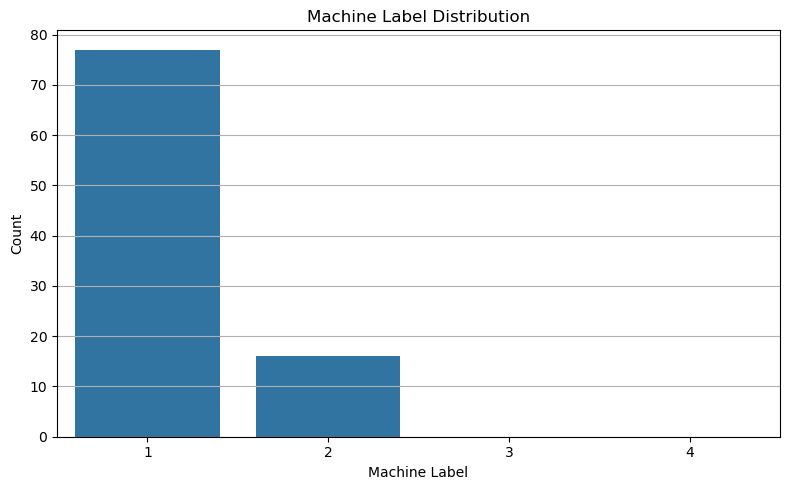

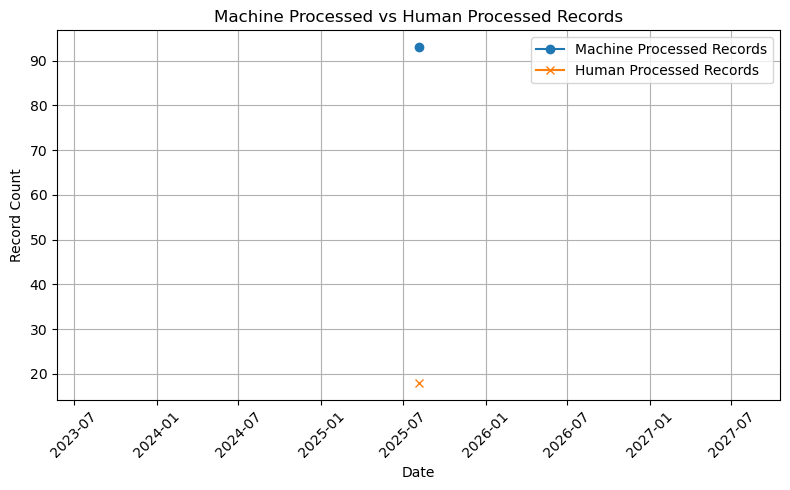

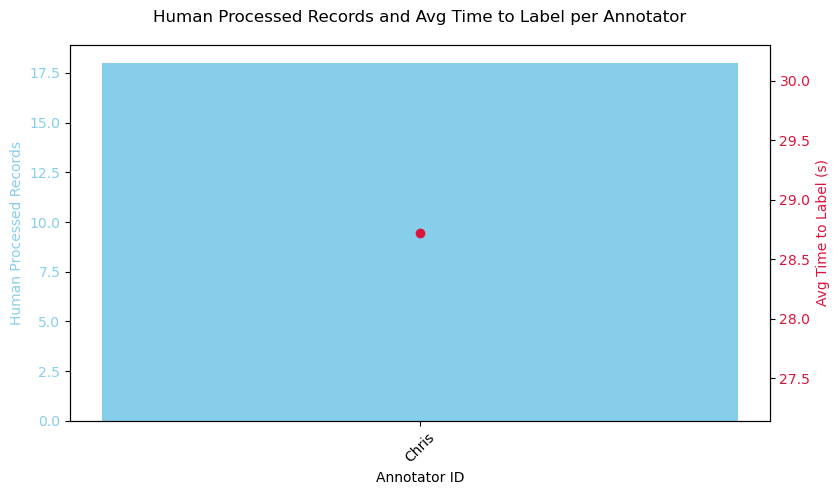



Below are the detailed breakdown of the differences between machine labelled results and human labelled results: 

machine_label  human_label
1.0            2.0            1
2.0            1.0            1
               3.0            4
               4.0            2
dtype: int64


Below are detailed human notes made on translated records:

Annotator Chris has made the following notes:

On task household-accessories_2025-08-05_1, with an original machine label of 2.0 and an updated human label of 1.0 ==>
    the original title is silicone basting brush for bbq pastry and baking - heat-resistant easy to clean,
    the translated title is 硅胶烧烤蛋糕刷 - 耐热易清洁,
    annotator has made the following suggestions: No comments made
            
On task household-accessories_2025-08-05_2, with an original machine label of 2.0 and an updated human label of 3.0 ==>
    the original title is 4pcs silicone egg frying ring fry fried poacher mould perfect for eggs pancakes,
    the translated title is

In [85]:
'''-----------------------------------------------------------------------------------------------------------------------------------------------------
Dashboard
------------------------------------------------------------------------------------------------------------------------------------------------------'''
# Descriptions
description = """
This AI-powered DataOps pipeline focuses on title translation from the eBay UK category Household Accessories & Supplies → Kitchen Tools & Gadgets. 
The source data is in English (en) and is translated using the gpt-4o model to Chinese (cn). 
Post-translation, the output undergoes a structured human-in-the-loop review using gpt-4.1 for review on the translated results. 
Each record is versioned under pipeline_version = 1.0 and dataset_version = 1.0 to ensure full traceability and reproducibility. 
"""
print(description)

# KPIs
table_data = [
    ["Pipeline Health", "Total Records", total, "Total number of extracted raw records before cleaning."],
    ["Pipeline Health", "Cleaned Records", cleaned, "Number of records retained after data cleaning and deduplication."],
    ["Pipeline Health", "Translated Records", processed, "Number of cleaned records eligible for translation and review."],
    ["Pipeline Health", "Cleaning Rate", cleaning_rate, "Percentage of raw records retained after cleaning and deduplication."],
    ["Pipeline Health", "Translation Rate", translation_rate, "Percentage of total raw records that were eligible for translation after cleaning."],
    
    ["Model Performance", "Accepted Records", accepted, "Number of records accepted automatically."],
    ["Model Performance", "Acceptance Rate", accept_rate, "Percentage of processed records that were accepted."],
    ["Model Performance", "Average Machine Label", machine_label, "Mean value of machine-assigned labels across all records."],
    ["Model Performance", "Average Machine Confidence", machine_confidence, "Average confidence score of machine-generated labels."],
    
    ["Human QA", "Reviewed Records", reviewed, "Number of records that are rejected automatially and therefore fully reviewed by a human annotator."],
    ["Human QA", "Spot-Checked Records", checked, "Number of records reviewed by a human via spot-check rather than full audit."],
    ["Human QA", "Spot-Check Rate", check_rate, "Percentage of processed records that received a human spot-check."],
    ["Human QA", "Average Human Label", human_label, "Mean value of human-assigned labels across reviewed records."],
    
    ["Model Evaluation", "Agreement Rate", agree_rate, "Percentage of reviewed + checked records where machine and human labels agreed."],
    ["Model Evaluation", "Adjusted Acceptance Rate", accept_rate, "Percentage of processed records that were accepted subjected to human spot check and review."],
    
    ["Annotation Efficiency", "Average Human Time to Label", time_to_label, "Average time taken by a human annotator to label a record."]
    
]

df_kpis = pd.DataFrame(table_data, columns=["KPI Category", "KPI Name", "KPI Value", "KPI Explanation"])


def format_kpi_value(val):
    if isinstance(val, (int, str)):
        return val
    elif isinstance(val, float):
        return round(val, 2)
    return val

with pd.option_context('display.max_colwidth', None):
    display(
        df_kpis.style
            .hide(axis='index')
            .format({"KPI Value": format_kpi_value})
)

# Charts
df_output["date"] = df_output["last_updated"].dt.date

# 1. Distribution of machine_label
label_counts = df_output["machine_label"].value_counts().sort_index()
label_counts = label_counts.reindex([1, 2, 3, 4], fill_value=0)

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Machine Label Distribution")
plt.xlabel("Machine Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Line chart of processed records vs reviewed + checked records per day
daily_counts = df_output.groupby("date").agg(
    machine_records=("translated_title", "count"),
    human_records=("decision", lambda x: ((x == "Human_Review") | (x == "Human_Spot_Check")).sum())
).reset_index()

plt.figure(figsize=(8, 5))
plt.plot(daily_counts["date"], daily_counts["machine_records"], label="Machine Processed Records", marker="o")
plt.plot(daily_counts["date"], daily_counts["human_records"], label="Human Processed Records", marker="x")
plt.title("Machine Processed vs Human Processed Records")
plt.xlabel("Date")
plt.ylabel("Record Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Combo chart: bar for reviewed+checked count, line for avg time_to_label per annotator
annotator_stats = df_output[df_output["decision"].isin(["Human_Review", "Human_Spot_Check"])].groupby("annotator_id").agg(
    human_records=("decision", "count"),
    avg_time_to_label=("human_time_to_label", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(8.5, 5))

# Bar chart for count
ax1.bar(annotator_stats["annotator_id"], annotator_stats["human_records"], color="skyblue", label="Human Processed Records")
ax1.set_xlabel("Annotator ID")
ax1.set_ylabel("Human Processed Records", color="skyblue")
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(annotator_stats["annotator_id"], rotation=45)

# Line chart for avg time
ax2 = ax1.twinx()
ax2.plot(annotator_stats["annotator_id"], annotator_stats["avg_time_to_label"], color="crimson", marker="o", label="Avg Time to Label")
ax2.set_ylabel("Avg Time to Label (s)", color="crimson")
ax2.tick_params(axis='y', labelcolor='crimson')

fig.suptitle("Human Processed Records and Avg Time to Label per Annotator")
fig.tight_layout()
plt.show()


# Additional information

print("\n\nBelow are the detailed breakdown of the differences between machine labelled results and human labelled results: \n")
print(df_output[df_output['human_label'] != df_output['machine_label']].groupby(['machine_label', 'human_label']).size())


print('\n\nBelow are detailed human notes made on translated records:' + '\n')

for annotator in df_output['annotator_id'][df_output['annotator_id'].notnull()].unique():
    print(f"Annotator {annotator} has made the following notes:" + '\n')
    for index, row in df_output[df_output['annotator_id']==annotator].iterrows():
        print(
            f"""On task {row['task_id']}, with an original machine label of {row['machine_label']} and an updated human label of {row['human_label']} ==>
    the original title is {row['clean_title']},
    the translated title is {row['translated_title']},
    annotator has made the following suggestions: {row['human_notes'] if row['human_notes'] else 'No comments made'}
            """
            )